In [21]:
# Rileggi il CSV con separatore '\t' e encoding utf-16 per ottenere le colonne corrette
import pandas as pd
df = pd.read_csv('balance backtest from 2020 eurchf.csv', encoding='utf-16', sep='\t')
df.head()

,<DATE>,<BALANCE>,<EQUITY>,<DEPOSIT LOAD>
0,2020.01.01 00:00,10000.00,10000.00,0.0000
1,2020.01.01 23:33,10000.29,9996.61,0.0000
2,2020.01.02 01:50,10000.29,10000.29,33.3323
3,2020.01.02 01:50,10000.29,10000.29,0.0000
4,2020.01.02 16:34,10002.02,10000.08,0.0000


In [22]:
# Mostra i nomi delle colonne e i tipi di dato
print(df.columns)
print(df.dtypes)

Index(['<DATE>', '<BALANCE>', '<EQUITY>', '<DEPOSIT LOAD>'], dtype='object')
<DATE>             object
<BALANCE>         float64
<EQUITY>          float64
<DEPOSIT LOAD>    float64
dtype: object


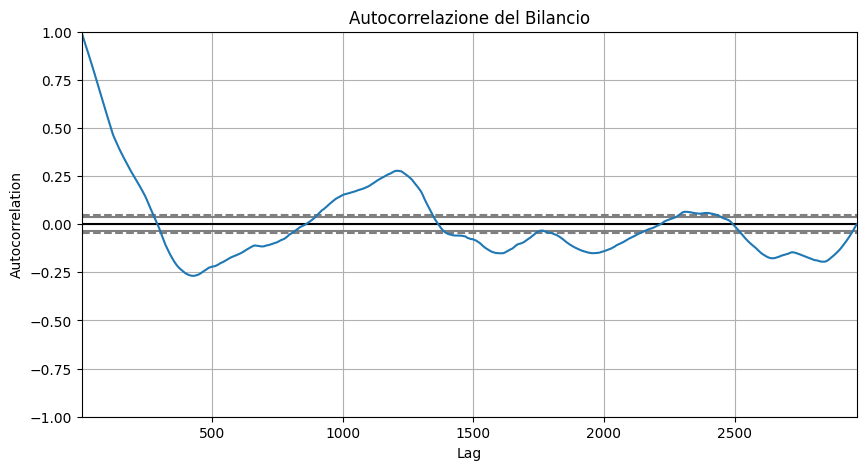

In [23]:
# Plot dell'autocorrelazione della colonna <BALANCE>
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(10,5))
autocorrelation_plot(df['<BALANCE>'])
plt.title('Autocorrelazione del Bilancio')
plt.show()

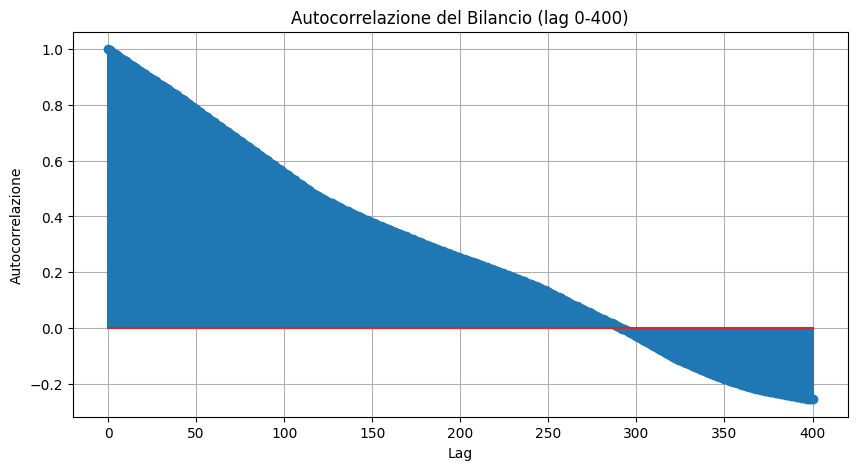

In [24]:
# Plot autocorrelazione del bilancio zoomato fino al lag 400
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

balance = df['<BALANCE>']
autocorr_vals = acf(balance, nlags=400, fft=True)

plt.figure(figsize=(10,5))
plt.stem(range(401), autocorr_vals)
plt.xlabel('Lag')
plt.ylabel('Autocorrelazione')
plt.title('Autocorrelazione del Bilancio (lag 0-400)')
plt.grid(True)
plt.show()

## Interpretazione del grafico di autocorrelazione
L’autocorrelazione del bilancio mostra come i valori futuri del bilancio siano correlati con i valori passati. Dal grafico ottenuto:
- L’autocorrelazione è molto alta per i primi lag (vicino a 1), il che è normale per una serie cumulativa come il bilancio: ogni valore dipende fortemente dal precedente.
- L’autocorrelazione scende rapidamente e oscilla intorno allo zero per lag più alti, con alcune oscillazioni positive e negative.
- Le bande tratteggiate rappresentano l’intervallo di confidenza: dove la linea blu esce da queste bande, l’autocorrelazione è statisticamente significativa.
**Interpretazione pratica:**
- Il bilancio della strategia non mostra autocorrelazione significativa a lag elevati, quindi non ci sono pattern di dipendenza a lungo termine evidenti.
- L’alta autocorrelazione iniziale è tipica di una serie cumulativa e non indica necessariamente inefficienze o pattern sfruttabili.
- Se la linea blu restasse fuori dalle bande per molti lag, potrebbe indicare pattern o problemi strutturali nella strategia.
In sintesi: il bilancio segue un comportamento atteso per una equity line di trading, senza evidenti autocorrelazioni anomale a lungo termine. Se vuoi analizzare la serie dei rendimenti (differenze giornaliere), potresti trovare informazioni più utili sulla dipendenza temporale della strategia.

In [25]:
# Plot interattivo del bilancio e del prezzo close (prezzo interpolato sui timestamp del bilancio)
import plotly.graph_objects as go
import pandas as pd

# Per il bilancio: <DATE> contiene già data e ora, convertilo in datetime
df['DATETIME'] = pd.to_datetime(df['<DATE>'], format='%Y.%m.%d %H:%M', errors='coerce')

# Per i prezzi: unisci <DATE> e <TIME> e converti in datetime
df_price = pd.read_csv('EURCHF BARS 30m.csv', sep='\t')
df_price['DATETIME'] = pd.to_datetime(df_price['<DATE>'] + ' ' + df_price['<TIME>'], format='%Y.%m.%d %H:%M:%S', errors='coerce')

# Imposta l'indice per interpolare
df_price = df_price.set_index('DATETIME')
df_interp = df.set_index('DATETIME').copy()
df_interp['CLOSE_interp'] = df_price['<CLOSE>'].reindex(df_interp.index, method='ffill')

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_interp.index, y=df_interp['<BALANCE>'], mode='lines', name='Bilancio'))
fig.add_trace(go.Scatter(x=df_interp.index, y=df_interp['CLOSE_interp'], mode='lines', name='Prezzo Close (interpolato)', yaxis='y2'))
fig.update_layout(
    title='Bilancio cumulativo e Prezzo Close interpolato (interattivo)',
    xaxis_title='Data',
    yaxis=dict(title='Bilancio'),
    yaxis2=dict(title='Prezzo Close', overlaying='y', side='right', showgrid=False),
    template='plotly_white'
    )
fig.show()

In [26]:
# Analisi: correlazione tra rolling returns del bilancio e indicatori di volatilità del prezzo
import numpy as np

# Rolling returns del bilancio (differenza percentuale su 10 step)
window_ret = 10
df_interp['returns'] = df_interp['<BALANCE>'].pct_change(window_ret)

# Calcola indicatori di volatilità sui prezzi
window_vol = 30
df_price['std_rolling'] = df_price['<CLOSE>'].rolling(window=window_vol).std()
df_price['var_rolling'] = df_price['<CLOSE>'].rolling(window=window_vol).var()
df_price['osc_perc'] = (df_price['<HIGH>'].rolling(window=window_vol).max() - df_price['<LOW>'].rolling(window=window_vol).min()) / df_price['<CLOSE>'].rolling(window=window_vol).mean()
df_price['tr'] = np.maximum(df_price['<HIGH>'] - df_price['<LOW>'], np.abs(df_price['<HIGH>'] - df_price['<CLOSE>'].shift(1)), np.abs(df_price['<LOW>'] - df_price['<CLOSE>'].shift(1)))
df_price['atr'] = df_price['tr'].rolling(window=window_vol).mean()

# Interpola gli indicatori sui timestamp del bilancio
for col in ['std_rolling', 'var_rolling', 'osc_perc', 'atr']:
    df_interp[col] = df_price[col].reindex(df_interp.index, method='ffill')

# Calcola la correlazione (anticorrelazione) tra rolling returns e ciascun indicatore
corrs = {}
for col in ['std_rolling', 'var_rolling', 'osc_perc', 'atr']:
    corr = df_interp['returns'].corr(df_interp[col])
    corrs[col] = corr

# Trova l'indicatore con la correlazione (in valore assoluto) più forte
best = min(corrs, key=lambda k: abs(corrs[k])) if min(corrs.values(), key=abs) < 0 else max(corrs, key=lambda k: abs(corrs[k]))

print('Correlazioni tra rolling returns e indicatori di volatilità:')
for k, v in corrs.items():
    print(f'{k}: {v:.3f}')
print(f'\nIndicatore con la correlazione (in valore assoluto) più forte: {best} ({corrs[best]:.3f})')

# Plot bilancio, rolling returns e l'indicatore migliore
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_interp.index, y=df_interp['returns'], mode='lines', name='Rolling Returns'))
fig.add_trace(go.Scatter(x=df_interp.index, y=df_interp[best], mode='lines', name=f'{best}'))
fig.update_layout(title=f'Rolling Returns vs {best}', xaxis_title='Data', yaxis_title='Valore', template='plotly_white')
fig.show()

Correlazioni tra rolling returns e indicatori di volatilità:
std_rolling: -0.063
var_rolling: -0.061
osc_perc: -0.041
atr: 0.019

Indicatore con la correlazione (in valore assoluto) più forte: std_rolling (-0.063)


In [27]:
# Scatter plot tra rolling returns e l'indicatore di volatilità con la correlazione più forte
import plotly.express as px

x = df_interp[best]
y = df_interp['returns']

fig = px.scatter(x=x, y=y, labels={'x': best, 'y': 'Rolling Returns'}, title=f'Scatter: {best} vs Rolling Returns')
fig.show()

In [28]:
# Esplora un set molto più ampio di combinazioni di rolling window per returns e volatilità e mostra la matrice delle correlazioni
import pandas as pd
import numpy as np
import plotly.express as px

returns_windows = list(range(2, 61, 2))  # da 2 a 60 con step 2
vol_windows = list(range(5, 121, 5))    # da 5 a 120 con step 5
indicators = ['std_rolling', 'var_rolling', 'osc_perc', 'atr']

results = {}
for win_ret in returns_windows:
    df_interp[f'ret_{win_ret}'] = df_interp['<BALANCE>'].pct_change(win_ret)
    for win_vol in vol_windows:
        # Ricalcola indicatori di volatilità per questa finestra
        df_price[f'std_{win_vol}'] = df_price['<CLOSE>'].rolling(window=win_vol).std()
        df_price[f'var_{win_vol}'] = df_price['<CLOSE>'].rolling(window=win_vol).var()
        df_price[f'osc_{win_vol}'] = (df_price['<HIGH>'].rolling(window=win_vol).max() - df_price['<LOW>'].rolling(window=win_vol).min()) / df_price['<CLOSE>'].rolling(window=win_vol).mean()
        df_price['tr'] = np.maximum(df_price['<HIGH>'] - df_price['<LOW>'], np.abs(df_price['<HIGH>'] - df_price['<CLOSE>'].shift(1)), np.abs(df_price['<LOW>'] - df_price['<CLOSE>'].shift(1)))
        df_price[f'atr_{win_vol}'] = df_price['tr'].rolling(window=win_vol).mean()
        # Interpola
        for ind, col in zip(indicators, [f'std_{win_vol}', f'var_{win_vol}', f'osc_{win_vol}', f'atr_{win_vol}']):
            df_interp[f'{ind}_{win_vol}'] = df_price[col].reindex(df_interp.index, method='ffill')
            # Calcola correlazione
            corr = df_interp[f'ret_{win_ret}'].corr(df_interp[f'{ind}_{win_vol}'])
            results[(win_ret, win_vol, ind)] = corr

# Crea DataFrame per heatmap per ogni indicatore
for ind in indicators:
    matrix = np.zeros((len(returns_windows), len(vol_windows)))
    for i, win_ret in enumerate(returns_windows):
        for j, win_vol in enumerate(vol_windows):
            matrix[i, j] = results[(win_ret, win_vol, ind)]
    df_matrix = pd.DataFrame(matrix, index=[f'ret_{w}' for w in returns_windows], columns=[f'vol_{w}' for w in vol_windows])
    fig = px.imshow(df_matrix, text_auto=False, color_continuous_scale='RdBu', origin='lower', aspect='auto', title=f'Correlazione returns vs {ind}')
    fig.update_layout(xaxis_title='Finestra volatilità', yaxis_title='Finestra returns')
    fig.show()

/tmp/ipykernel_23013/190648997.py:22: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_23013/190648997.py:15: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_23013/190648997.py:16: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_23013/190648997.py:17: Performance

In [29]:
# Scatter plot tra rolling returns (ret_4) e volatilità (std_rolling_120) con retta di regressione e R^2
import plotly.express as px
import numpy as np

x = df_interp['std_rolling_120']
y = df_interp['ret_4']

# Calcola i parametri della retta di regressione (y = m*x + q)
mask = (~np.isnan(x)) & (~np.isnan(y))
m, q = np.polyfit(x[mask], y[mask], 1)
y_fit = m * x + q

# Calcola R^2
ss_res = np.sum((y[mask] - (m * x[mask] + q))**2)
ss_tot = np.sum((y[mask] - np.mean(y[mask]))**2)
r2 = 1 - ss_res/ss_tot
print(f'Retta di regressione: y = {m:.4g}x + {q:.4g}   R^2 = {r2:.4f}')

fig = px.scatter(x=x, y=y, labels={'x': 'Volatilità (std_rolling_120)', 'y': 'Rolling Returns (ret_4)'}, title='Scatter: Volatilità (120) vs Returns (4)')
fig.add_scatter(x=x, y=y_fit, mode='lines', name='Regressione', line=dict(color='red'))
fig.show()

Retta di regressione: y = -0.1445x + 0.0002475   R^2 = 0.1616


In [30]:
# Analisi: correlazione tra forward returns dell’equity e rolling std dell’equity stessa su molte finestre
import numpy as np
import pandas as pd
import plotly.express as px

forward_windows = list(range(2, 61, 2))  # da 2 a 60 con step 2
std_windows = list(range(5, 121, 5))    # da 5 a 120 con step 5

results = {}
for win_fwd in forward_windows:
    # Forward returns: (shiftato in avanti, quindi futuro rispetto al punto attuale)
    df_interp[f'fwd_ret_{win_fwd}'] = df_interp['<BALANCE>'].shift(-win_fwd) / df_interp['<BALANCE>'] - 1
    for win_std in std_windows:
        df_interp[f'std_{win_std}'] = df_interp['<BALANCE>'].rolling(window=win_std).std()
        # Calcola correlazione tra forward returns e rolling std
        corr = df_interp[f'fwd_ret_{win_fwd}'].corr(df_interp[f'std_{win_std}'])
        results[(win_fwd, win_std)] = corr

# Crea matrice per heatmap
matrix = np.zeros((len(forward_windows), len(std_windows)))
for i, win_fwd in enumerate(forward_windows):
    for j, win_std in enumerate(std_windows):
        matrix[i, j] = results[(win_fwd, win_std)]
df_matrix = pd.DataFrame(matrix, index=[f'fwd_{w}' for w in forward_windows], columns=[f'std_{w}' for w in std_windows])

fig = px.imshow(df_matrix, text_auto=False, color_continuous_scale='RdBu', origin='lower', aspect='auto', title='Correlazione forward returns vs rolling std equity')
fig.update_layout(xaxis_title='Finestra rolling std', yaxis_title='Finestra forward returns')
fig.show()

/tmp/ipykernel_23013/4081080740.py:12: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_23013/4081080740.py:14: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_23013/4081080740.py:14: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_23013/4081080740.py:14: Perform

In [31]:
# Regressione multipla: indicatore combinato delle rolling std più anticorrelate con i forward returns (usando la window con la massima anticorrelazione)
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.linear_model import LinearRegression

# 1. Trova le 5 combinazioni (finestra forward, finestra std) con la correlazione più negativa (anticorrelate)
num_top = 5
sorted_corrs = sorted(results.items(), key=lambda x: x[1])  # dal più negativo al più positivo
top_combos = sorted_corrs[:num_top]  # prendi le più anticorrelate

print('Top combinazioni più anticorrelate:')
for (win_fwd, win_std), corr in top_combos:
    print(f'Forward {win_fwd}, Std {win_std}: corr = {corr:.3f}')

# 2. Trova la finestra forward che ha la massima anticorrelazione (più negativa)
best_combo = sorted_corrs[0][0]  # (win_fwd, win_std) della massima anticorrelazione
best_fwd = best_combo[0]
print(f'\nUserò come forward return la finestra {best_fwd}, che ha la massima anticorrelazione.')

# 3. Costruisci la matrice X delle rolling std per le finestre selezionate, y = forward return con la finestra migliore
X = []
col_names = []
for win_fwd, win_std in [x[0] for x in top_combos]:
    col = f'std_{win_std}'
    X.append(df_interp[col].values)
    col_names.append(col)
X = np.vstack(X).T
y = df_interp[f'fwd_ret_{best_fwd}'].values

# 4. Rimuovi i NaN
mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
X_clean = X[mask]
y_clean = y[mask]

# 5. Regressione multipla
reg = LinearRegression()
reg.fit(X_clean, y_clean)
indicator = reg.predict(X_clean)

# 6. Plot: indicatore combinato vs forward returns
fig = px.scatter(x=indicator, y=y_clean, labels={'x': 'Indicatore combinato', 'y': f'Forward Return ({best_fwd})'}, title='Indicatore combinato vs Forward Return')
fig.add_traces(px.line(x=indicator, y=indicator, labels={'x': 'Indicatore combinato', 'y': 'Indicatore combinato'}).data)
fig.show()

Top combinazioni più anticorrelate:
Forward 12, Std 15: corr = -0.042
Forward 18, Std 10: corr = -0.042
Forward 14, Std 15: corr = -0.041
Forward 16, Std 10: corr = -0.041
Forward 8, Std 20: corr = -0.040

Userò come forward return la finestra 12, che ha la massima anticorrelazione.


In [32]:
# Plot delle serie temporali: forward returns e rolling std per la combo più anticorrelata
import plotly.graph_objects as go

# Recupera finestre della combo più anticorrelata
win_fwd, win_std = best_combo
fwd_series = df_interp[f'fwd_ret_{win_fwd}']
std_series = df_interp[f'std_{win_std}']

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_interp.index, y=fwd_series, mode='lines', name=f'Forward Return ({win_fwd})'))
fig.add_trace(go.Scatter(x=df_interp.index, y=std_series, mode='lines', name=f'Rolling Std ({win_std})', yaxis='y2'))
fig.update_layout(
    title=f'Serie temporali: Forward Return ({win_fwd}) e Rolling Std ({win_std})',
    xaxis_title='Data',
    yaxis=dict(title=f'Forward Return ({win_fwd})'),
    yaxis2=dict(title=f'Rolling Std ({win_std})', overlaying='y', side='right', showgrid=False),
    template='plotly_white'
    )
fig.show()

In [34]:
# Matrice di correlazione: rolling std del prezzo vs forward returns del balance (con attenzione ai timestamp)
import numpy as np
import pandas as pd
import plotly.express as px

forward_windows = list(range(2, 180, 2))  # da 2 a 60 con step 2
std_windows = list(range(5, 180, 5))    # da 5 a 120 con step 5

results = {}
for win_fwd in forward_windows:
    # Forward returns sul balance (shiftato in avanti)
    df_interp[f'fwd_ret_{win_fwd}'] = df_interp['<BALANCE>'].shift(-win_fwd) / df_interp['<BALANCE>'] - 1
    for win_std in std_windows:
        # Rolling std sul prezzo close, calcolata su df_price (che ha timestamp diversi)
        df_price[f'std_price_{win_std}'] = df_price['<CLOSE>'].rolling(window=win_std).std()
        # Interpola la rolling std del prezzo sui timestamp del balance
        std_interp = df_price[f'std_price_{win_std}'].reindex(df_interp.index, method='ffill')
        # Calcola correlazione tra forward returns e rolling std interpolata
        corr = df_interp[f'fwd_ret_{win_fwd}'].corr(std_interp)
        results[(win_fwd, win_std)] = corr

# Crea matrice per heatmap
matrix = np.zeros((len(forward_windows), len(std_windows)))
for i, win_fwd in enumerate(forward_windows):
    for j, win_std in enumerate(std_windows):
        matrix[i, j] = results[(win_fwd, win_std)]
df_matrix = pd.DataFrame(matrix, index=[f'fwd_{w}' for w in forward_windows], columns=[f'std_{w}' for w in std_windows])

fig = px.imshow(df_matrix, text_auto=False, color_continuous_scale='RdBu', origin='lower', aspect='auto', title='Correlazione rolling std prezzo vs forward returns balance')
fig.update_layout(xaxis_title='Finestra rolling std prezzo', yaxis_title='Finestra forward returns balance')
fig.show()

/tmp/ipykernel_23013/1966200025.py:15: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_23013/1966200025.py:15: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_23013/1966200025.py:15: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_23013/1966200025.py:15: Perform